In [1]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np

from superfv import EulerSolver, plot_2d_slice, turbulent_power_specta, plot_timeseries
from superfv.initial_conditions import decaying_isotropic_turbulence

In [2]:
seed = 1
N = 64
T = [0.05]  # [0.05, 0.1, 0.15]

configs = {
    "p0": dict(riemann_solver="hllc", p=0),
    "MUSCL-Hancock": dict(
        riemann_solver="hllc",
        p=1,
        MUSCL=True,
        MUSCL_limiter="PP2D",
        flux_recipe=2,
    ),
    "ZS3": dict(
        riemann_solver="hllc",
        p=3,
        flux_recipe=2,
        lazy_primitives=True,
        ZS=True,
        GL=True,
        include_corners=True,
        PAD={"rho": (0, None)},
    ),
    "MM3": dict(
        riemann_solver="hllc",
        p=3,
        flux_recipe=2,
        lazy_primitives=True,
        MOOD=True,
        limiting_vars=("rho", "vx", "vy"),
        cascade="muscl",
        MUSCL_limiter="PP2D",
        max_MOOD_iters=1,
        blend=True,
        NAD=True,
        NAD_rtol=1e-2,
        NAD_atol=1e-8,
        include_corners=True,
        PAD={"rho": (0, None)},
    ),
}

In [3]:
sims = {}
for name, config in configs.items():
    print(f"Running simulation: {name}")
    sim = EulerSolver(
        ic=partial(decaying_isotropic_turbulence, seed=seed, M=10, slope=-5 / 3),
        isothermal=True,
        nx=N,
        ny=N,
        **config,
    )

    try:
        sim.run(
            T,
            q_max=2,
            allow_overshoot=True,
            muscl_hancock=config.get("MUSCL", False),
            log_freq=20,
        )
        sims[name] = sim
    except RuntimeError as e:
        print(f"Simulation '{name}' failed: {e}")

Running simulation: p0
Step #91 @ t=5.03e-02 | dt=6.49e-04 | min(rho)=7.93e-03, min(P)=7.93e-03 | (done)                   
Running simulation: MUSCL-Hancock
Step #103 @ t=5.01e-02 | dt=5.77e-04 | min(rho)=1.13e-03, min(P)=1.13e-03 | (done)                  
Running simulation: ZS3
Step #103 @ t=5.03e-02 | dt=5.16e-04 | min(rho)=2.44e-04, min(P)=2.44e-04 | (done)                  
Running simulation: MM3
Step #124 @ t=5.05e-02 | dt=5.56e-04 | min(rho)=1.73e-03, min(P)=1.73e-03 | (done)                  


/Users/jonathan/Desktop/superfv/superfv/visualization.py:38: UserWarning: Cell-centered coordinate 0.05 not exactly matched in mesh; using nearest: 0.050524
  warnings.warn(
/Users/jonathan/Desktop/superfv/superfv/visualization.py:38: UserWarning: Cell-centered coordinate 0.05 not exactly matched in mesh; using nearest: 0.050524
  warnings.warn(


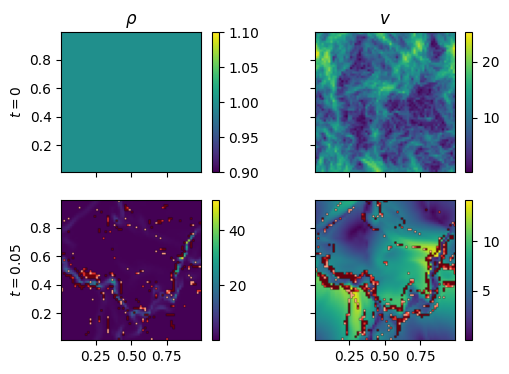

In [4]:
sim = sims["MM3"]

fig, axs = plt.subplots(
    len(T) + 1, 2, sharex=True, sharey=True, figsize=(6, (len(T) + 1) * 2)
)

axs[0, 0].set_title(r"$\rho$")
axs[0, 1].set_title(r"$v$")

for i, t in enumerate([0] + T):
    axs[i, 0].set_ylabel(f"$t={t}$")
    plot_2d_slice(
        sim,
        axs[i, 0],
        "rho",
        cell_averaged=True,
        colorbar=True,
        t=t,
        overlay_troubles=True,
        troubles_alpha=1.0,
    )
    plot_2d_slice(
        sim,
        axs[i, 1],
        "v",
        cell_averaged=True,
        colorbar=True,
        t=t,
        overlay_troubles=True,
        troubles_alpha=1.0,
    )

(<matplotlib.image.AxesImage at 0x11cb08350>,
 <matplotlib.colorbar.Colorbar at 0x11d4eaae0>)

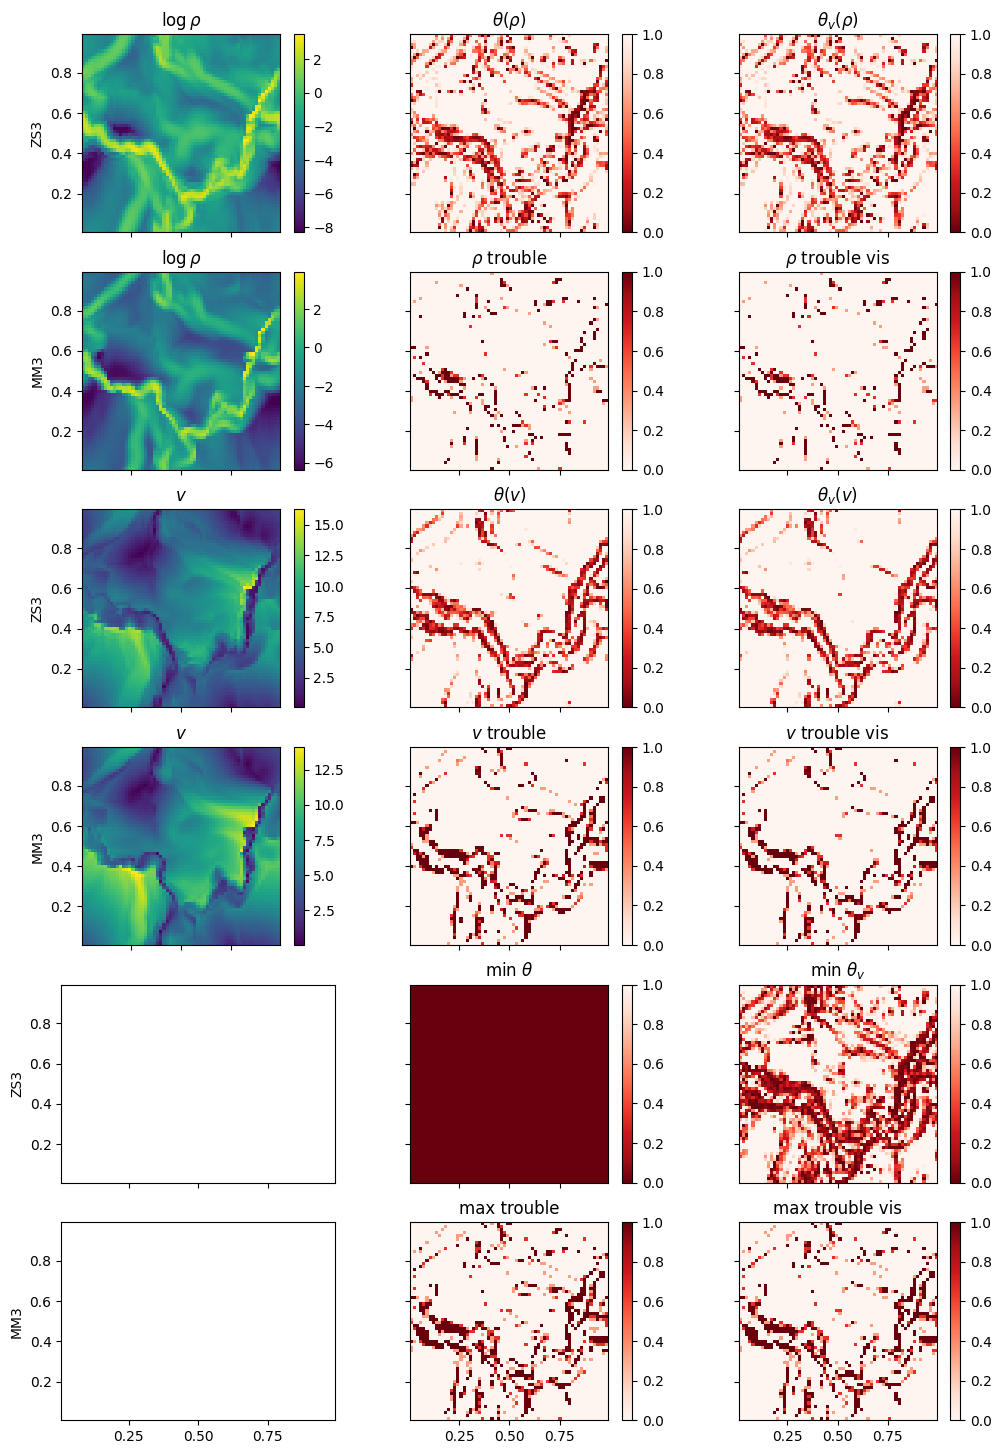

In [5]:
sim1 = sims["ZS3"]
sim2 = sims["MM3"]

fig, axs = plt.subplots(6, 3, sharex=True, sharey=True, figsize=(12, 18))

axs[0, 0].set_ylabel("ZS3")
axs[0, 0].set_title(r"$\log \rho$")
axs[0, 1].set_title(r"$\theta(\rho)$")
axs[0, 2].set_title(r"$\theta_v(\rho)$")

axs[1, 0].set_ylabel("MM3")
axs[1, 0].set_title(r"$\log \rho$")
axs[1, 1].set_title(r"$\rho$ trouble")
axs[1, 2].set_title(r"$\rho$ trouble vis")

axs[2, 0].set_ylabel("ZS3")
axs[2, 0].set_title(r"$v$")
axs[2, 1].set_title(r"$\theta(v)$")
axs[2, 2].set_title(r"$\theta_v(v)$")

axs[3, 0].set_ylabel("MM3")
axs[3, 0].set_title(r"$v$")
axs[3, 1].set_title(r"$v$ trouble")
axs[3, 2].set_title(r"$v$ trouble vis")

axs[4, 0].set_ylabel("ZS3")
axs[4, 1].set_title(r"min $\theta$")
axs[4, 2].set_title(r"min $\theta_v$")

axs[5, 0].set_ylabel("MM3")
axs[5, 1].set_title(r"max trouble")
axs[5, 2].set_title(r"max trouble vis")

style = dict(cell_averaged=True, colorbar=True)
theta_style = dict(theta=True, cmap="Reds_r", vmin=0, vmax=1, colorbar=True)
trouble_style = dict(troubles=True, cmap="Reds", vmin=0, vmax=1, colorbar=True)

plot_2d_slice(sim1, axs[0, 0], "rho", func=lambda x: np.log(x), **style)
plot_2d_slice(sim1, axs[0, 1], "rho", visualization=False, **theta_style)
plot_2d_slice(sim1, axs[0, 2], "rho", visualization=True, **theta_style)

plot_2d_slice(sim2, axs[1, 0], "rho", func=lambda x: np.log(x), **style)
plot_2d_slice(sim2, axs[1, 1], "rho", visualization=False, **trouble_style)
plot_2d_slice(sim2, axs[1, 2], "rho", visualization=True, **trouble_style)

plot_2d_slice(sim1, axs[2, 0], "v", **style)
plot_2d_slice(sim1, axs[2, 1], "v", visualization=False, **theta_style)
plot_2d_slice(sim1, axs[2, 2], "v", visualization=True, **theta_style)

plot_2d_slice(sim2, axs[3, 0], "v", **style)
plot_2d_slice(sim2, axs[3, 1], "v", visualization=False, **trouble_style)
plot_2d_slice(sim2, axs[3, 2], "v", visualization=True, **trouble_style)

plot_2d_slice(sim1, axs[4, 1], "min", visualization=False, **theta_style)
plot_2d_slice(sim1, axs[4, 2], "min", visualization=True, **theta_style)

plot_2d_slice(sim2, axs[5, 1], "max", visualization=False, **trouble_style)
plot_2d_slice(sim2, axs[5, 2], "max", visualization=True, **trouble_style)

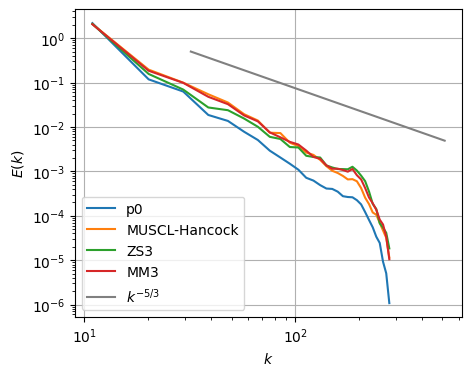

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.set_xlabel(r"$k$")
ax.set_ylabel(r"$E(k)$")
ax.set_xscale("log")
ax.set_yscale("log")

for name, sim in sims.items():
    w = sim.snapshots[-1]["w"]
    k_centers, E_k = turbulent_power_specta(
        sim.xp, sim.variable_index_map, w, sim.mesh, nbins=30, binmode="linear"
    )

    ax.plot(k_centers, E_k, marker="none", mfc="none", linestyle="-", label=name)

ax.plot(
    [32, 512], [5e-1, 5e-1 * (512 / 32) ** (-5 / 3)], label=r"$k^{-5/3}$", color="gray"
)

ax.legend()
ax.grid()

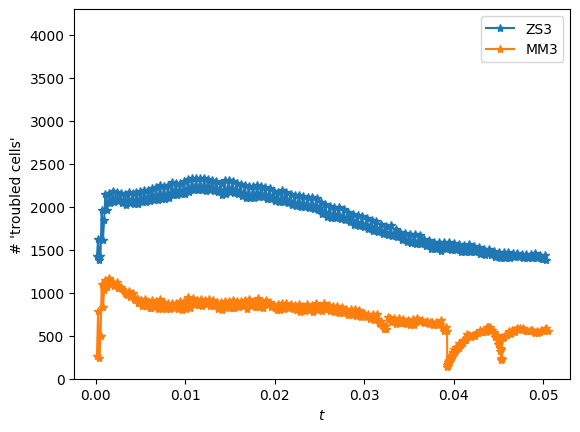

In [7]:
fig, ax = plt.subplots()
ax.set_ylim(0, 1.05 * N**2)

ax.set_xlabel(r"$t$")
ax.set_ylabel("# 'troubled cells'")

plot_timeseries(
    sims["ZS3"],
    ax,
    "max",
    one_minus_theta=True,
    visualization=True,
    label="ZS3",
    marker="*",
)
plot_timeseries(
    sims["MM3"], ax, "max", troubles=True, visualization=True, label="MM3", marker="*"
)
ax.legend()